In [1]:
import os
import numpy
import time
import signal
import binascii
import threading
import subprocess
from PIL import Image
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from raw_features import ByteHistogram, ByteEntropyHistogram

%matplotlib inline

## 读取数据地址

In [2]:
data_dir = "../data_rec_mzpe"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [3]:
# train_black_path = []
# for parent, dirnames, filenames in os.walk(os.path.join(data_dir, "train")):
#     if "black" in parent:
#         for filename in filenames:
#             fp = os.path.join(parent, filename)
#             train_black_path.append(os.path.abspath(fp))

# train_white_path = []
# for parent, dirnames, filenames in os.walk(os.path.join(data_dir, "train")):
#     if "white" in parent:
#         for filename in filenames:
#             fp = os.path.join(parent, filename)
#             train_white_path.append(os.path.abspath(fp))

# test_path = []
# for parent, dirnames, filenames in os.walk(os.path.join(data_dir, "test")):
#     for filename in filenames:
#         fp = os.path.join(parent, filename)
#         test_path.append(os.path.abspath(fp))

# real_path = []
# for parent, dirnames, filenames in os.walk(os.path.join(data_dir, "real")):
#     if "1_data_real" in parent:
#         for filename in filenames:
#             fp = os.path.join(parent, filename)
#             real_path.append(os.path.abspath(fp))

# with open("train_black_path.pkl", 'wb') as f:
#     pickle.dump(train_black_path, f)

# with open("train_white_path.pkl", 'wb') as f:
#     pickle.dump(train_white_path, f)

# with open("test_path.pkl", 'wb') as f:
#     pickle.dump(test_path, f)

# with open("real_path.pkl", 'wb') as f:
#     pickle.dump(real_path, f)

with open("train_black_path.pkl", 'rb') as f:
    train_black_path = pickle.load(f)

with open("train_white_path.pkl", 'rb') as f:
    train_white_path = pickle.load(f)

with open("test_path.pkl", 'rb') as f:
    test_path = pickle.load(f)

with open("real_path.pkl", 'rb') as f:
    real_path = pickle.load(f)

拷贝一份

In [4]:
# if not os.path.exists("gray"):
#     os.makedirs("gray/black")
#     os.makedirs("gray/white")
#     os.makedirs("gray/test")
#     os.makedirs("gray/real")

# for pt in train_black_path:
#     os.system("cp {0} {1}".format(pt, "gray/black/"))
# for pt in train_white_path:
#     os.system("cp {0} {1}".format(pt, "gray/white/"))
# for pt in test_path:
#     os.system("cp {0} {1}".format(pt, "gray/test/"))
# for pt in real_path[6007:]:
#     os.system("cp {0} {1}".format(pt, "gray/real/"))

train_black_path = [pt.replace("data_rec_mzpe/train/1_2000_", "jupyterlab/gray/") for pt in train_black_path]
train_white_path = [pt.replace("data_rec_mzpe/train/1_4000_", "jupyterlab/gray/") for pt in train_white_path]
test_path = [pt.replace("data_rec_mzpe/test/data", "jupyterlab/gray/test") for pt in test_path]
real_path = [pt.replace("data_rec_mzpe/real/1_data_real", "jupyterlab/gray/real") for pt in real_path]
real_path = [pt.replace("data_rec_mzpe/real/2_data_real", "jupyterlab/gray/real") for pt in real_path]
real_path = [pt.replace("data_rec_mzpe/real/3_data_real", "jupyterlab/gray/real") for pt in real_path]

## 提取灰度图信息

In [6]:
empty = threading.Semaphore(value=20)

def getMatrixfrom_bin(filename, width):  #生成灰度图
    with open(filename, 'rb') as f:
        content = f.read()
    hexst = binascii.hexlify(content)  #将二进制文件转换为十六进制字符串
    fh = numpy.array(
        [int(hexst[i:i + 2], 16) for i in range(0, len(hexst), 2)])  #按字节分割
    rn = int(len(fh) / width)
    fh = numpy.reshape(fh[:rn * width], (-1, width))  #根据设定的宽度生成矩阵
    fh = numpy.uint8(fh)
    return fh

def generate_gray(fp):
    filename = fp
    try:
        im = Image.fromarray(getMatrixfrom_bin(filename, 512))  #转换为图像
        im = im.resize((512, 512))
        PNG = filename + '.png'
        im.save(PNG)
    except Exception as e:
        pass
    os.remove(fp)

    empty.release()

In [7]:
# with tqdm(total=6000, ncols=80, desc="gray") as pbar:
#     for fp in train_black_path:
#         empty.acquire()
#         t = threading.Thread(target=generate_gray, args=(fp, ), daemon=True)
#         t.start()
#         pbar.update(1)
#     for fp in train_white_path:
#         empty.acquire()
#         t = threading.Thread(target=generate_gray, args=(fp, ), daemon=True)
#         t.start()
#         pbar.update(1)

# with tqdm(total=6000, ncols=80, desc="gray") as pbar:
#     for fp in test_path:
#         empty.acquire()
#         t = threading.Thread(target=generate_gray, args=(fp, ), daemon=True)
#         t.start()
#         pbar.update(1)

with tqdm(total=len(real_path[6007:]), ncols=80, desc="gray") as pbar:
    for fp in real_path[6007:]:
        empty.acquire()
        t = threading.Thread(target=generate_gray, args=(fp, ), daemon=True)
        t.start()
        pbar.update(1)

gray: 100%|█████████████████████████████████| 3010/3010 [41:53<00:00,  1.20it/s]


## 读取直方图数据和打标

In [5]:
raw_data, raw_labels = [], []

test_data_feature, real_data_feature = [], []

with tqdm(total=6000*2 + len(real_path), ncols=80, desc="gray") as pbar:
    for fp in train_black_path:
        image = Image.open(fp+'.png')
        image_data = np.array(image)
        raw_data.append(image_data)
        raw_labels.append(1)
        pbar.update(1)
    for fp in train_white_path:
        image = Image.open(fp+'.png')
        image_data = np.array(image)
        raw_data.append(image_data)
        raw_labels.append(0)
        pbar.update(1)
    for fp in test_path:
        image = Image.open(fp+'.png')
        image_data = np.array(image)
        test_data_feature.append(image_data)
        pbar.update(1)
    for fp in real_path:
        image = Image.open(fp+'.png')
        image_data = np.array(image)
        real_data_feature.append(image_data)
        pbar.update(1)

gray: 100%|██████████████████████████████| 21017/21017 [01:09<00:00, 302.95it/s]


## 超参数

In [6]:
TRAIN_SIZE = 0.8
VAL_SIZE = 0.1
TEST_SIZE = 0.1
SEED = 4396

WIDTH, HEIGHT = 512, 512
BATCH_SIZE = 32
EPOCH = 300
SHUFFLE = False
CLASSES = 2

LR = 1e-5

## 打乱顺序

In [7]:
np.random.seed(SEED)
tf.random.set_seed(SEED)

img_data, labels = np.array(raw_data, dtype=np.float32), np.array(raw_labels, dtype=np.int32)

index = list(range(len(labels)))
np.random.shuffle(index)

img_data = img_data[index]
labels = labels[index]

## 划分数据集

In [14]:
train_image, test_image, train_label, test_label = train_test_split(
    img_data,
    labels,
    test_size=TEST_SIZE,
    stratify=labels,
    random_state=SEED)
train_image, valid_image, train_label, valid_label = train_test_split(
    train_image,
    train_label,
    test_size=VAL_SIZE,
    stratify=train_label,
    random_state=SEED)

## 加载Dataset

In [15]:
train_ds = tf.data.Dataset.from_tensor_slices((train_image, train_label)) \
                            .batch(BATCH_SIZE) \
                            .prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

valid_ds = tf.data.Dataset.from_tensor_slices((valid_image, valid_label)) \
                            .batch(BATCH_SIZE) \
                            .prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_image, test_label)) \
                            .batch(BATCH_SIZE) \
                            .prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

## 构建模型

In [29]:
# 构建模型
inputs = layers.Input(shape=(WIDTH, HEIGHT), dtype='float32')
inputs_re = tf.reshape(inputs, (-1, WIDTH, HEIGHT, 1))
Conv_1 = layers.Convolution2D(30, (3, 3),
                              strides=2,
                              padding='same',
                              activation='relu')(inputs_re)
Max_pool_1 = layers.MaxPooling2D((2, 2), strides=2)(Conv_1)
Conv_2 = layers.Convolution2D(50, (3, 3),
                              strides=2,
                              padding='same',
                              activation='relu')(Max_pool_1)
Max_pool_2 = layers.MaxPooling2D((2, 2), strides=2)(Conv_2)
Conv_3 = layers.Convolution2D(100, (3, 3),
                              strides=2,
                              padding='same',
                              activation='relu')(Max_pool_2)
Max_pool_3 = layers.MaxPooling2D((2, 2), strides=2)(Conv_3)
Flat = layers.Flatten()(Max_pool_3)
Dense_1 = layers.Dense(500, activation='tanh')(Flat)
dropout = layers.Dropout(0.5)(Dense_1)
outputs = layers.Dense(1, activation='sigmoid')(dropout)


model = models.Model(inputs=inputs, outputs=outputs)

In [30]:
# 自定义评估指标
def score(y_true, y_pred):
    y_true = tf.cast(tf.reshape(y_true, (-1,)), tf.int32)
    y_pred = tf.cast(tf.math.round(tf.reshape(y_pred, (-1,))), tf.int32)

    tp = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), dtype=tf.float32))
    fn = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 0)), dtype=tf.float32))
    fp = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 0), tf.equal(y_pred, 1)), dtype=tf.float32))
    tn = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 0), tf.equal(y_pred, 0)), dtype=tf.float32))

    result = (tp/(tp+fn)) - 0.9*(fp/(fp+tn))
    
    return result

model.compile(optimizer=tf.keras.optimizers.Nadam(LR),
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [31]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512)]        0         
_________________________________________________________________
tf_op_layer_Reshape_1 (Tenso [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 30)      300       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 30)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 50)        13550     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 50)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 100)       4510

## 训练

In [32]:
history = model.fit(
        train_ds,
        validation_data=valid_ds,
        # class_weight=class_weight_dict,
        epochs=EPOCH,
        workers=4,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, min_delta=1e-4, mode='min'),
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.5, verbose=0)])

Epoch 1/300
152/152 [==============================] - 9s 56ms/step - loss: 0.2638 - accuracy: 0.9187 - val_loss: 0.1581 - val_accuracy: 0.9574 - lr: 1.0000e-05
Epoch 2/300
152/152 [==============================] - 8s 52ms/step - loss: 0.2052 - accuracy: 0.9426 - val_loss: 0.1491 - val_accuracy: 0.9593 - lr: 1.0000e-05
Epoch 3/300
152/152 [==============================] - 8s 52ms/step - loss: 0.2020 - accuracy: 0.9467 - val_loss: 0.1443 - val_accuracy: 0.9593 - lr: 1.0000e-05
Epoch 4/300
152/152 [==============================] - 8s 54ms/step - loss: 0.1973 - accuracy: 0.9453 - val_loss: 0.1392 - val_accuracy: 0.9593 - lr: 1.0000e-05
Epoch 5/300
152/152 [==============================] - 8s 52ms/step - loss: 0.1793 - accuracy: 0.9473 - val_loss: 0.1317 - val_accuracy: 0.9593 - lr: 1.0000e-05
Epoch 6/300
152/152 [==============================] - 9s 59ms/step - loss: 0.1791 - accuracy: 0.9467 - val_loss: 0.1287 - val_accuracy: 0.9593 - lr: 1.0000e-05
Epoch 7/300
152/152 [=============

In [33]:
dfhistory = pd.DataFrame(history.history)

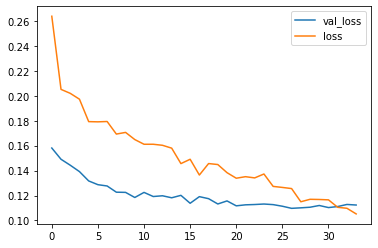

In [34]:
dfhistory[['val_loss', 'loss']].plot()

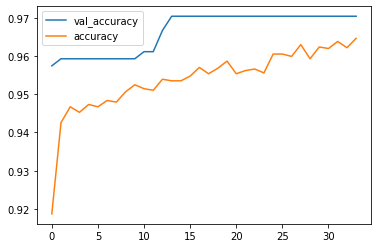

In [35]:
dfhistory[['val_accuracy', 'accuracy']].plot()

In [36]:
# dfhistory[['val_score', 'score']].plot()

## 测试集

In [14]:
predict = model.evaluate(img_data, labels)

188/188 [==============================] - 4s 23ms/step - loss: 0.0920 - accuracy: 0.9680


In [38]:
# model.save('./gray/gray_0.97.h5', save_format="tf")

## 测试数据

In [12]:
model = tf.keras.models.load_model('./gray/gray_0.97.h5')

In [40]:
test_data_feature = np.array(test_data_feature)
predict_test = model.predict(test_data_feature)

In [41]:
test_data_labels = [0 if v < 0.5 else 1 for v in predict_test]

In [42]:
sum(test_data_labels), len(test_data_labels)

(1813, 6000)

## 输出模型结果

In [5]:
raw_data, raw_labels = [], []

test_data_feature, real_data_feature = [], []

with tqdm(total=6000*2 + len(real_path), ncols=80, desc="gray") as pbar:
    for fp in train_black_path:
        image = Image.open(fp+'.png')
        image_data = np.array(image)
        raw_data.append(image_data)
        raw_labels.append(1)
        pbar.update(1)
    for fp in train_white_path:
        image = Image.open(fp+'.png')
        image_data = np.array(image)
        raw_data.append(image_data)
        raw_labels.append(0)
        pbar.update(1)
    for fp in test_path:
        image = Image.open(fp+'.png')
        image_data = np.array(image)
        test_data_feature.append(image_data)
        pbar.update(1)
    for fp in real_path:
        image = Image.open(fp+'.png')
        image_data = np.array(image)
        real_data_feature.append(image_data)
        pbar.update(1)
raw_data, raw_labels = np.array(raw_data, dtype=np.float32), np.array(raw_labels, dtype=np.int32)
test_data_feature, real_data_feature = np.array(test_data_feature, dtype=np.float32), np.array(real_data_feature, dtype=np.float32)

gray: 100%|██████████████████████████████| 21017/21017 [01:04<00:00, 327.49it/s]


In [6]:
model = tf.keras.models.load_model('./gray/gray_0.97.h5')

In [7]:
gray_train = model.predict(raw_data)
gray_test = model.predict(test_data_feature)
gray_real = model.predict(real_data_feature)

In [8]:
gray_train.shape, gray_test.shape, gray_real.shape

((6000, 1), (6000, 1), (9017, 1))

In [9]:
with open("gray/gray_train_old.csv", "wb") as fp:
    pickle.dump(gray_train, fp)
with open("gray/gray_test_old.csv", "wb") as fp:
    pickle.dump(gray_test, fp)
with open("gray/gray_real_old.csv", "wb") as fp:
    pickle.dump(gray_real, fp)

In [10]:
sum([0 if v < 0.5 else 1 for v in gray_test])

1813

In [11]:
sum([0 if v < 0.5 else 1 for v in gray_real])

2381